# 步骤1.2：数据统计与分析

本 Notebook 对应于 `plan1.md` 中的 `#### 1.2 数据统计与分析`。

我们将进行以下分析：
1.  **Query 文本分析**：
    *   统计 Query 文本长度分布。
    *   统计每个 Query 对应的商品数量分布。
2.  **图片特征分析**：
    *   分析商品图片的分辨率（已统一为 224x224）。
    *   分析商品图片的颜色分布。
3.  **关键词分析**：
    *   分析文本描述的关键词分布，识别高频词汇。

In [1]:
import sys
import os

# # 安装必要的库
# print("正在安装所需库...")
# !{sys.executable} -m pip install jieba wordcloud matplotlib seaborn pandas
# print("库安装完成。")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import jieba
from wordcloud import WordCloud
from collections import Counter

# 设置中文字体，以防绘图时出现乱码
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"设置中文字体失败: {e}")
    print("绘图中的中文可能会显示为方框。请确保您的系统已安装 SimHei 字体，或修改为其他可用中文字体。")

# 导入数据加载器
sys.path.append(os.path.abspath('.'))
from data_loader import DataLoader

# 初始化 DataLoader
loader = DataLoader()

print("环境准备就绪。")

正在安装所需库...
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 4.3 MB/s  0:00:04 eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 854.2 kB/s  0:00:00a 0:00:01
  DEPRECATION: Building 'jieba' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'jieba'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314509 sha256=f5ad925c183d5364797136019a9ffce2ff6cf8768d4d390d4397026a2bbb2860
  Stored in directory: /home/xiuminke/.cache/pip/wheels/37/08/79/ea7c0d2ca823affa13f89586a5a9eff8dd6a

2025-11-04 12:39:06,204 - INFO - 初始化数据加载器，数据目录: /mnt/d/forCoding_data/Tianchi_MUGE/originalData/Multimodal_Retrieval


环境准备就绪。


In [11]:
from matplotlib.font_manager import FontProperties, fontManager
myfont = FontProperties(fname="/mnt/d/forCoding_code/SimHei.ttf")

## 1. 加载数据

首先，我们加载所有需要用到的 Query 数据。

In [3]:
train_queries_df = loader.load_queries(split='train')
valid_queries_df = loader.load_queries(split='valid')

print(f"训练集 Query 数量: {len(train_queries_df)}")
print(f"验证集 Query 数量: {len(valid_queries_df)}")
print("训练集 Query 示例:")
display(train_queries_df.head())

2025-11-04 12:39:17,882 - INFO - 加载train查询数据: /mnt/d/forCoding_data/Tianchi_MUGE/originalData/Multimodal_Retrieval/MR_train_queries.jsonl
加载train查询数据: 248786it [00:00, 293146.95it/s]
2025-11-04 12:39:18,828 - INFO - 成功加载train查询数据，共248786条
2025-11-04 12:39:18,838 - INFO - 加载valid查询数据: /mnt/d/forCoding_data/Tianchi_MUGE/originalData/Multimodal_Retrieval/MR_valid_queries.jsonl
加载valid查询数据: 5008it [00:00, 352457.79it/s]
2025-11-04 12:39:18,857 - INFO - 成功加载valid查询数据，共5008条


训练集 Query 数量: 248786
验证集 Query 数量: 5008
训练集 Query 示例:


,query_id,query_text,item_ids
0,1,手机壳粘土,[97905]
1,2,男t丝光棉长袖,[1085941]
2,3,亚克力展示盒 门,[470515]
3,4,18650电池 进口,[524145]
4,5,子弹头蓝牙耳机,[779473]


In [4]:
train_queries_df.shape

(248786, 3)

## 2. Query 文本分析

### 2.1 Query 文本长度分布

2025-11-04 12:45:28,791 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:45:28,791 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:45:28,792 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:45:28,793 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:45:28,793 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:45:28,794 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:45:28,795 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-1

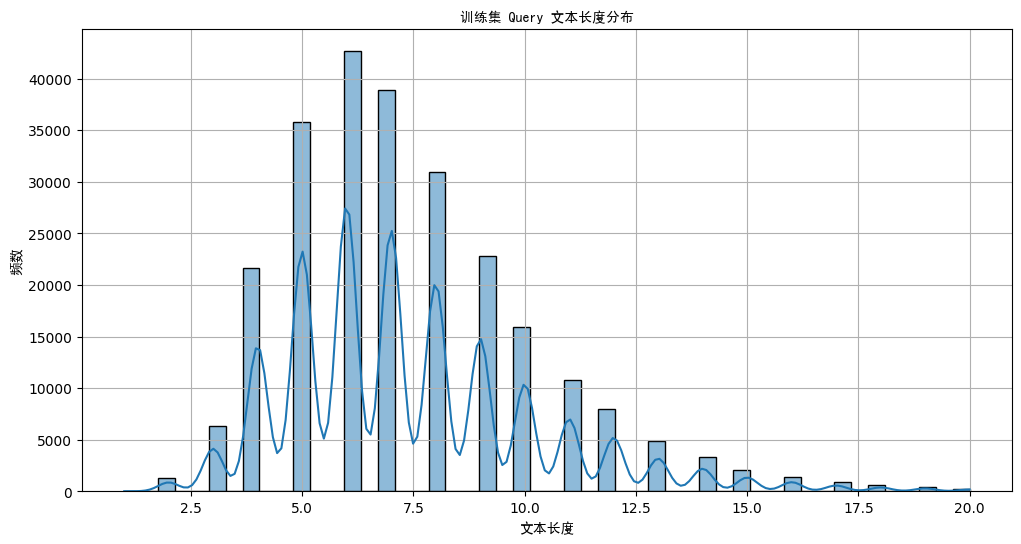

训练集 Query 文本长度统计信息:
count    248786.000000
mean          7.404557
std           2.799365
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max          20.000000
Name: query_length, dtype: float64


In [13]:
train_queries_df['query_length'] = train_queries_df['query_text'].str.len()

plt.figure(figsize=(12, 6))
sns.histplot(train_queries_df['query_length'], bins=50, kde=True)
plt.title('训练集 Query 文本长度分布', fontproperties = myfont)
plt.xlabel('文本长度', fontproperties = myfont)
plt.ylabel('频数', fontproperties = myfont)
plt.grid(True)
plt.show()

print("训练集 Query 文本长度统计信息:")
print(train_queries_df['query_length'].describe())

### 2.2 每个 Query 对应的商品数量分布

2025-11-04 12:46:15,724 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-04 12:46:15,777 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-04 12:46:15,803 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:46:15,804 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:46:15,804 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:46:15,805 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were 

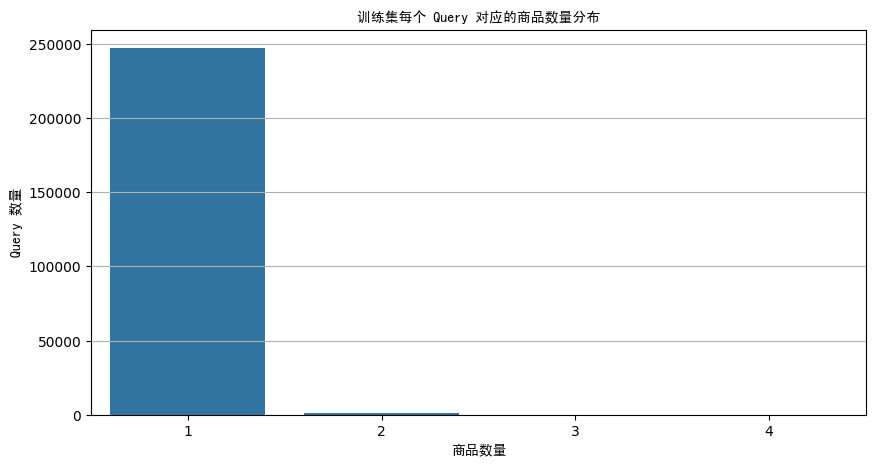

训练集每个 Query 对应的商品数量统计:
item_count
1    247321
2      1405
3        57
4         3
Name: count, dtype: int64


In [15]:
train_queries_df['item_count'] = train_queries_df['item_ids'].apply(len)

plt.figure(figsize=(10, 5))
sns.countplot(x='item_count', data=train_queries_df)
plt.title('训练集每个 Query 对应的商品数量分布', fontproperties = myfont)
plt.xlabel('商品数量', fontproperties = myfont)
plt.ylabel('Query 数量', fontproperties = myfont)
plt.grid(axis='y')
plt.show()

print("训练集每个 Query 对应的商品数量统计:")
print(train_queries_df['item_count'].value_counts())

## 3. 图片特征分析

### 3.1 图片分辨率分析

根据任务描述和 `data_loader.py` 的实现，所有图片都已经被统一缩放到了 224x224。我们加载一张图片来验证这一点。

2025-11-04 12:46:44,450 - INFO - 批量加载valid图片数据: /mnt/d/forCoding_data/Tianchi_MUGE/originalData/Multimodal_Retrieval/MR_valid_imgs.tsv
加载valid图片数据:   0%|                                                                          | 0/1 [00:00<?, ?it/s]
2025-11-04 12:46:47,023 - INFO - 已加载1张图片到内存
2025-11-04 12:46:47,023 - INFO - 成功创建valid图片映射字典，共1张图片


加载的示例图片 ID: 1000002
图片尺寸: (224, 224)
图片模式: RGB


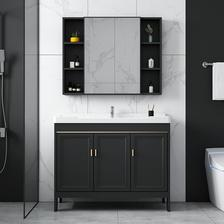

In [16]:
img_dict = loader.create_img_id_to_image_dict(split='valid', max_samples=1)
if img_dict:
    sample_img_id = list(img_dict.keys())[0]
    sample_img = img_dict[sample_img_id]
    if sample_img:
        print(f"加载的示例图片 ID: {sample_img_id}")
        print(f"图片尺寸: {sample_img.size}")
        print(f"图片模式: {sample_img.mode}")
        display(sample_img)
    else:
        print("无法加载示例图片数据。")
else:
    print("未能加载任何示例图片。")

### 3.2 图片颜色分布分析

我们加载少量样本图片，分析它们的平均颜色分布。

In [18]:
import warnings
warnings.filterwarnings("ignore")

2025-11-04 12:50:35,532 - INFO - 批量加载valid图片数据: /mnt/d/forCoding_data/Tianchi_MUGE/originalData/Multimodal_Retrieval/MR_valid_imgs.tsv
加载valid图片数据:  67%|███████████████████████████████████████████▎                     | 2/3 [00:00<00:00, 755.87it/s]
2025-11-04 12:50:38,256 - INFO - 已加载3张图片到内存
2025-11-04 12:50:38,256 - INFO - 成功创建valid图片映射字典，共3张图片
2025-11-04 12:50:38,269 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,271 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,271 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,272 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,273 - WARNING - findfont: Generic family 'sans-serif' not found

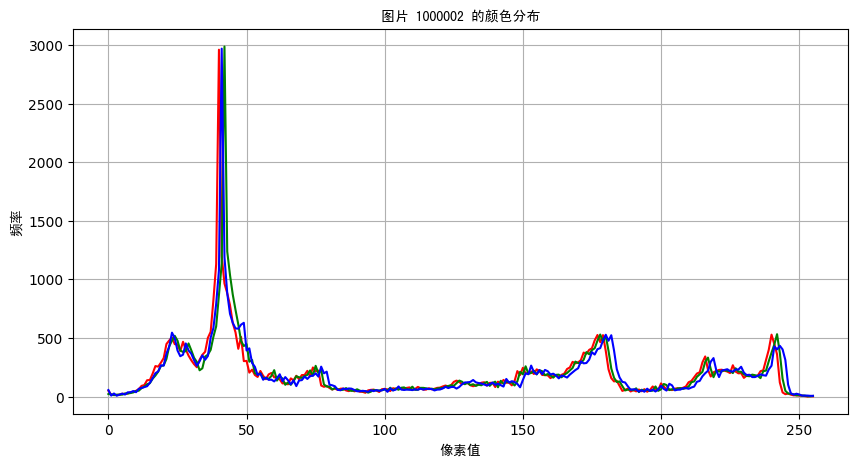

2025-11-04 12:50:38,363 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,364 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,365 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,366 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,366 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,367 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,368 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-1

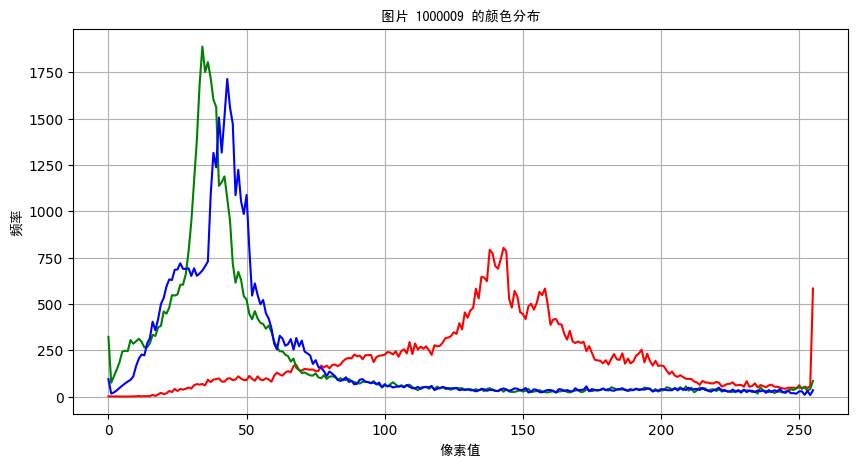

2025-11-04 12:50:38,451 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,451 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,452 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,452 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,453 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,454 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 12:50:38,454 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-1

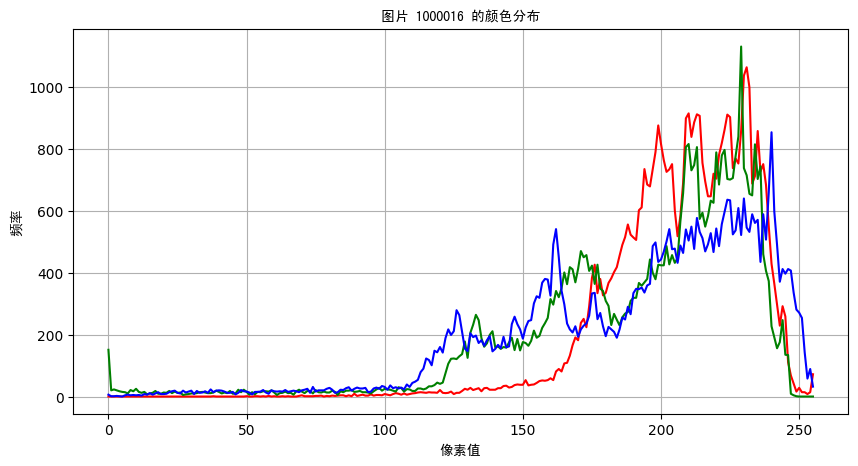

In [19]:
def plot_color_histogram(image, title):
    """绘制单张图片的颜色直方图"""
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(10, 5))
    
    for i, color in enumerate(colors):
        histogram = image.histogram()
        plt.plot(histogram[i*256:(i+1)*256], color=color)
    
    plt.title(title, fontproperties = myfont)
    plt.xlabel('像素值', fontproperties = myfont)
    plt.ylabel('频率', fontproperties = myfont)
    plt.grid(True)
    plt.show()

# 加载几张图片进行分析
img_sample_dict = loader.create_img_id_to_image_dict(split='valid', max_samples=3)

for img_id, img in img_sample_dict.items():
    if img:
        plot_color_histogram(img, f'图片 {img_id} 的颜色分布')
    else:
        print(f"图片 {img_id} 数据为空，无法分析颜色分布。")

## 4. 文本关键词分析

我们对训练集中的 Query 文本进行分词，并统计高频词，以了解用户的搜索意图和领域特征。

In [21]:
# 定义一个简单的停用词列表（可以根据需要扩展）
stopwords = set(['的', '女', '男', '新款', '夏季', '春季', '秋季', '冬季', '韩版'])

def get_keywords(text_series, top_k=20):
    """从文本序列中提取关键词"""
    all_text = ''.join(text_series.dropna())
    
    # 使用 jieba 分词
    words = jieba.lcut(all_text)
    
    # 过滤掉停用词和单字词
    filtered_words = [word for word in words if word not in stopwords and len(word) > 1]
    
    # 统计词频
    word_counts = Counter(filtered_words)
    
    return word_counts.most_common(top_k)

top_keywords = get_keywords(train_queries_df['query_text'], top_k=30)

print("训练集 Top 30 关键词:")
print(top_keywords)

Building prefix dict from the default dictionary ...
2025-11-04 12:54:28,483 - DEBUG - Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
2025-11-04 12:54:28,743 - DEBUG - Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.285 seconds.
2025-11-04 12:54:28,770 - DEBUG - Loading model cost 0.285 seconds.
Prefix dict has been built successfully.
2025-11-04 12:54:28,771 - DEBUG - Prefix dict has been built successfully.


训练集 Top 30 关键词:
[('儿童', 4078), ('套装', 2890), ('手机', 2701), ('外套', 2652), ('连衣裙', 2648), ('2020', 2484), ('家用', 2426), ('男士', 2215), ('白色', 2085), ('黑色', 2070), ('短袖', 1914), ('上衣', 1870), ('宝宝', 1848), ('宽松', 1781), ('纯棉', 1717), ('加厚', 1631), ('女士', 1560), ('休闲', 1500), ('春秋', 1481), ('大码', 1433), ('旗舰店', 1408), ('女童', 1395), ('婴儿', 1380), ('打底', 1357), ('裤子', 1343), ('衬衫', 1335), ('秋冬', 1333), ('真皮', 1294), ('时尚', 1270), ('红色', 1262)]


In [29]:
# import matplotlib.pyplot as plt

# # 设置中文字体为SimHei
# plt.rcParams['font.sans-serif'] = ['SimHei']
# # 解决负号显示为方块的问题
# plt.rcParams['axes.unicode_minus'] = False

2025-11-04 13:31:26,729 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:31:26,746 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:31:26,752 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:31:26,753 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:31:26,753 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:31:26,754 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:31:26,755 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-1

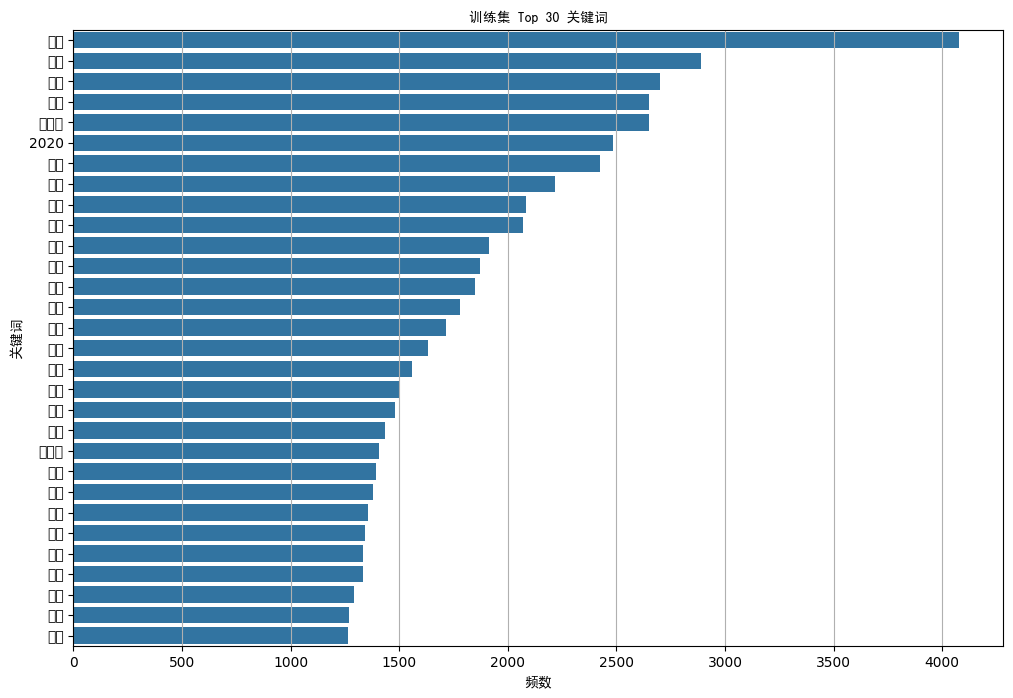

In [30]:
# 可视化高频词
top_words_df = pd.DataFrame(top_keywords, columns=['word', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=top_words_df)
plt.title('训练集 Top 30 关键词', fontproperties=myfont)
plt.xlabel('频数', fontproperties=myfont)
plt.ylabel('关键词', fontproperties=myfont)
plt.grid(axis='x')
plt.show()

2025-11-04 13:38:23,379 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:38:23,384 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:38:23,385 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:38:23,385 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:38:23,386 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:38:23,386 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-11-04 13:38:23,409 - WARNING - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2025-1

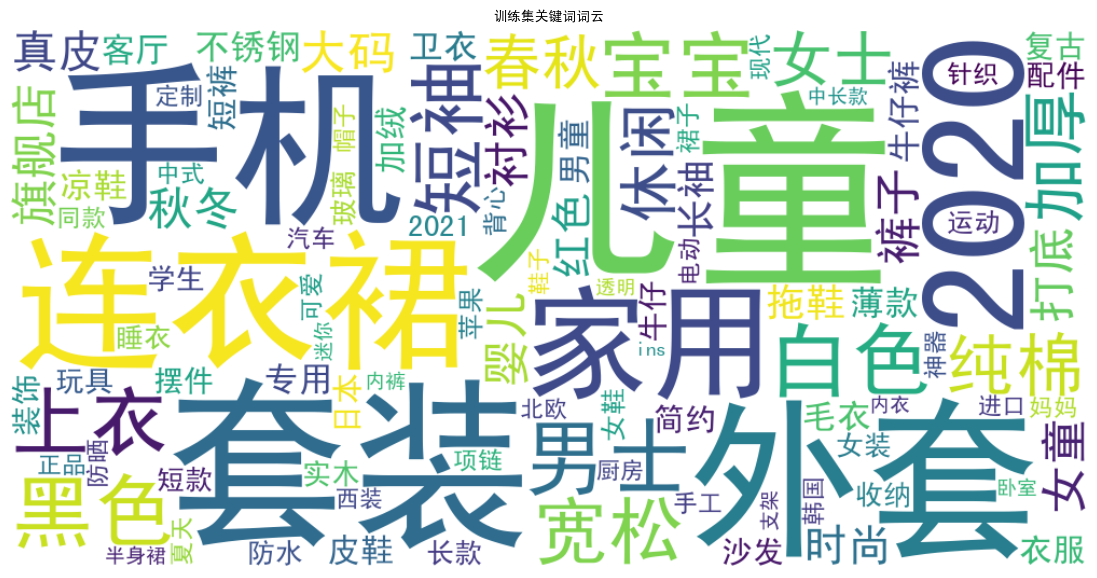

In [33]:
# 生成词云
word_counts = dict(get_keywords(train_queries_df['query_text'], top_k=100))

# 注意：请确保您的环境中已安装中文字体。WordCloud 需要指定字体路径才能正确显示中文。
# 这是一个常见的SimHei字体名称，如果您的系统没有，请替换为已有的字体，或提供字体文件的绝对路径。
# 常见的Linux字体路径: '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'
font_path = "/mnt/d/forCoding_code/SimHei.ttf" # 尝试使用字体名称
try:
    wc = WordCloud(
        font_path=font_path,
        background_color='white',
        width=1000,
        height=500,
        max_words=100
    ).generate_from_frequencies(word_counts)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('训练集关键词词云', fontproperties=myfont)
    plt.show()
except Exception as e:
    print(f"生成词云失败: {e}")
    print("请尝试指定一个您系统中存在的中文字体文件路径（.ttf 或 .ttc 文件）。")

## 总结

通过本次分析，我们得到了以下结论：
1.  **Query 长度**：大部分 Query 长度集中在 5 到 15 个字符之间，说明用户倾向于使用简短的短语进行搜索。
2.  **商品数量**：绝大多数 Query 在训练集中对应 1-2 个商品，符合任务描述。
3.  **图片特征**：图片尺寸统一，颜色分布多样，符合电商商品图片的特点。
4.  **关键词**：识别出了如“连衣裙”、“T恤”、“裤子”等高频品类词，以及“宽松”、“显瘦”等修饰词，这为后续的特征工程和模型设计提供了方向。